In [18]:
import csv
import os.path
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import regularizers
from keras.layers.normalization import BatchNormalization

from rbflayer import RBFLayer, InitCentersRandom
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import *

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import math
import pandas as pd

This dataset summarizes a heterogeneous set of features about articles published by Mashable in a period of two years.

The goal is to predict the number of shares in social networks (popularity).<br>
<br>
Reference material <br>
http://benalexkeen.com/feature-scaling-with-scikit-learn/ <br>
https://github.com/PetraVidnerova/rbf_keras/blob/master/rbflayer.py <br>
https://archive.ics.uci.edu/ml/datasets/online+news+popularity <br><br>
Target is the last element, shares: Number of shares

In [19]:
# loading of dataset 
dataset = []
labels = []

def load_dataset(is_normalize=True, is_remove_outlier=True, select_top=20):
    global dataset, labels
    with open('OnlineNewsPopularity.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        header = next(reader) # the first row
        header = header[1:-1]
        header = [x.strip(' ') for x in header]
        
        temp_data = []
        temp_label = []

        for idx, row in enumerate(reader):            
            slice_row = row[1:-1]
            temp_data.append(slice_row)
            temp_label.append(row[-1])
        
        # convert elements to float        
        for idx, row in enumerate(temp_data):        
            dataset.append([float(i) for i in row[:]])
        for idx, row in enumerate(temp_label):
            labels.append(float(row))                
    
        if is_normalize:
            # it is important which type of normalization method you use
            scaler = preprocessing.StandardScaler()
            dataset = scaler.fit_transform(dataset)
            # last item uses MinMaxScaler
            labels = np.array(labels).reshape(-1, 1)
            scaler = preprocessing.RobustScaler()
            labels = scaler.fit_transform(labels)
            print('Data is normalize')
        else:
            print('No normalize apply')        
            
        if is_remove_outlier:
            dataset, labels = reject_outliers(dataset, labels)    
            
        if 0 < select_top < len(dataset):            
            top_features = pca_important_features(dataset, header, top=select_top)
            feature_keys = [f[1] for f in top_features]
            df = pd.DataFrame(dataset, columns=header)
            top_dataset = []
            for name in feature_keys:
#                 name = ' {0}'.format(name)
                top_dataset.append(df.loc[:, name])
            dataset = np.transpose(top_dataset)
            
    return np.array(dataset), np.array(labels).reshape(-1, 1)

def pca_important_features(dataset, header, top=10):
    scaleFeatures = True
    pca = PCA(n_components=5, svd_solver='full')
    pca.fit(dataset)
    T = pca.transform(dataset)
    top_features = extract_features(T, pca.components_, header, top)
    return top_features
    
def extract_features(transformed_features, components_, columns, top):
    num_columns = len(columns)

    # This funtion will project your *original* feature (columns)
    # onto your principal component feature-space, so that you can
    # visualize how "important" each one was in the
    # multi-dimensional scaling

    # Scale the principal components by the max value in
    # the transformed set belonging to that component
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])

    ## visualize projections

    # Sort each column by it's length. These are your *original*
    # columns, not the principal components.
    important_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    print("Features by top {0} importance:".format(top))
    for feature in important_features[:top]:
        print(feature)
    print()
    return important_features[:top]
        
def reject_outliers(dataset, labels, m=40):        
    """
    Higher the value 'm' more outliers
    """
    d = np.abs(labels - np.median(labels))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
        
    # remove outliers in dataset and labels
    sub_dataset = []
    sub_labels = []
    outlier_labels = []
    for idx, item in enumerate(s):        
        if item < m:
            sub_labels.append(labels[idx])
            sub_dataset.append(dataset[idx])        
        else:
            outlier_labels.append(labels[idx])
    print('Outlier removed: {0}'.format(len(outlier_labels)))
    return sub_dataset, sub_labels

In [20]:
# Splitting of dataset into train and test
# Dataset if normalize using MinMaxScaler
dataset = []
labels = []
dataset, labels = load_dataset(is_normalize=True, is_remove_outlier=True, select_top=20)
print('Dataset shape: {0}, Labels: {1}'.format(dataset.shape, labels.shape))

x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, shuffle=False, random_state=42)
print("x_train: {0}, y_train: {1}".format(x_train.shape, y_train.shape))
print("x_test: {0}, y_test: {1}".format(x_test.shape, y_test.shape))

# print(dataset[1])
# print(labels[:-10])

Data is normalize
Outlier removed: 554
Features by top 20 importance:
(6.827813863641121, 'min_negative_polarity')
(6.595119455530813, 'rate_negative_words')
(6.387680338480462, 'global_rate_negative_words')
(6.372956031560736, 'avg_negative_polarity')
(5.3943035307350415, 'global_sentiment_polarity')
(5.227351857914837, 'kw_avg_avg')
(5.166828898533202, 'kw_avg_max')
(5.1514040003044785, 'rate_positive_words')
(4.783510898063484, 'kw_max_max')
(4.623461109529173, 'timedelta')
(4.456103155589684, 'kw_min_min')
(4.449077298210287, 'LDA_04')
(4.433812293574422, 'global_subjectivity')
(4.3830556497589495, 'LDA_03')
(4.043766881660036, 'avg_positive_polarity')
(4.008090031950794, 'max_positive_polarity')
(3.9487548298223185, 'data_channel_is_tech')
(3.5201417859416653, 'kw_max_avg')
(3.458114995892193, 'global_rate_positive_words')
(3.337617397325415, 'kw_min_avg')

Dataset shape: (39090, 20), Labels: (39090, 1)
x_train: (31272, 20), y_train: (31272, 1)
x_test: (7818, 20), y_test: (7818, 1

dataset (39090, 20)
labels (39090, 1)
Labels max value: 12.891046386192018
Labels min value: -0.7545846817691478
Labels avg value: 0.6366970476948198


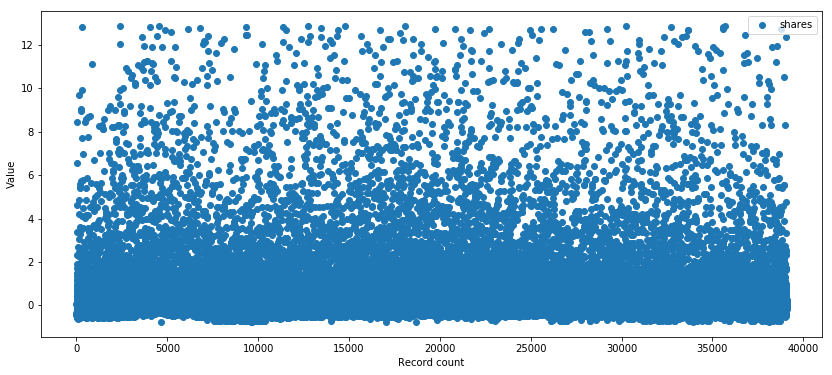

In [21]:
# Quick view of processed datasets
print('dataset {0}'.format(dataset.shape))
print('labels {0}'.format(labels.shape))
print('Labels max value: {0}'.format(np.max(labels)))
print('Labels min value: {0}'.format(np.min(labels)))
print('Labels avg value: {0}'.format(np.average(labels)))

def show_graph(data):
    plt.figure(figsize=(14,6))
    plt.xlabel("Record count")
    plt.ylabel("Value")
    plt.title("")
    x = list(range(len(data)))
    plt.scatter(x, [pt[0] for pt in data], label='shares')
    plt.legend(loc='upper right')
    plt.show()

def show_histogram(data):
    plt.figure(figsize=(14,6))
    plt.hist(data, 100)
    plt.show()

show_graph(labels)
# show_histogram(labels)

**Reference**<br>
*kernel_regularizer*: Regularizer function applied to the kernel weights matrix (see regularizer).<br>
*activity_regularizer*: Regularizer function applied to the output of the layer (its "activation").

In [22]:
# build model
l2_kernal = 0.001

# model = Sequential()
# model.add(Dense(2048, input_dim=59, activation='tanh'))
# model.add(Dropout(0.5))
# model.add(Dense(1024, activation='tanh'))
# model.add(Dropout(0.5))
# model.add(Dense(512, activation='tanh'))
# model.add(Dropout(0.5))
# model.add(Dense(512, activation='tanh'))
# model.add(Dropout(0.5))
# model.add(Dense(512, activation='tanh'))
# model.add(Dropout(0.5))
# model.add(Dense(256, activation='tanh'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

model = Sequential()
model.add(Dense(512, input_dim=20, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', activity_regularizer=regularizers.l2(l2_kernal)))

model.compile(loss='mean_squared_error',
              optimizer=RMSprop(lr=0.001),
              metrics=['mean_squared_error'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               10752     
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
__________

In [23]:
# training with callbacks
saved_weights_name = 'best_weights_mlp.h5'

# load weights if any
if os.path.isfile(saved_weights_name):
    model.load_weights(saved_weights_name)
    print("Weights loaded: {0}".format(saved_weights_name))

early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.0001,
                           patience=10,
                           mode='min',
                           verbose=1)

checkpoint = ModelCheckpoint(saved_weights_name,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min',
                             period=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=4,
                              min_lr=0.00001,
                              verbose=1)
    
# history = model.fit(x_train, y_train,
#                       epochs=50,
#                       validation_data=(x_test, y_test),
#                       callbacks=[early_stop, checkpoint, reduce_lr],
#                       verbose=1)

Weights loaded: best_weights_mlp.h5
Train on 31272 samples, validate on 7818 samples
Epoch 1/50
31272/31272 [==============================] - 4s 128us/step - loss: 3.1686 - mean_squared_error: 3.1074 - val_loss: 2.5485 - val_mean_squared_error: 2.4908

Epoch 00001: val_loss improved from inf to 2.54854, saving model to best_weights_mlp.h5
Epoch 2/50
31272/31272 [==============================] - 4s 127us/step - loss: 3.1633 - mean_squared_error: 3.1024 - val_loss: 2.5632 - val_mean_squared_error: 2.5056

Epoch 00002: val_loss did not improve
Epoch 3/50
31272/31272 [==============================] - 4s 135us/step - loss: 3.1689 - mean_squared_error: 3.1074 - val_loss: 2.5448 - val_mean_squared_error: 2.4857

Epoch 00003: val_loss improved from 2.54854 to 2.54479, saving model to best_weights_mlp.h5
Epoch 4/50
31272/31272 [==============================] - 6s 188us/step - loss: 3.1642 - mean_squared_error: 3.1029 - val_loss: 2.5530 - val_mean_squared_error: 2.4951

Epoch 00004: val_loss

7818/7818 [==============================] - 0s 36us/step
actual max 12.891046386192018
actual min -0.7524271844660194
actual median -0.05393743257820928
predict max 0.9968339800834656
predict min 0.000565664260648191
predict median 0.3817717134952545

loss: 2.553818
mean_squared_error: 2.495777
root_mse: 1.579803
explained_variance_score: -22.352761
mean_absolute_error: 0.853189
mean_squared_log_error: 0.415024
median_absolute_error: 0.513058
r2_score: -22.402747


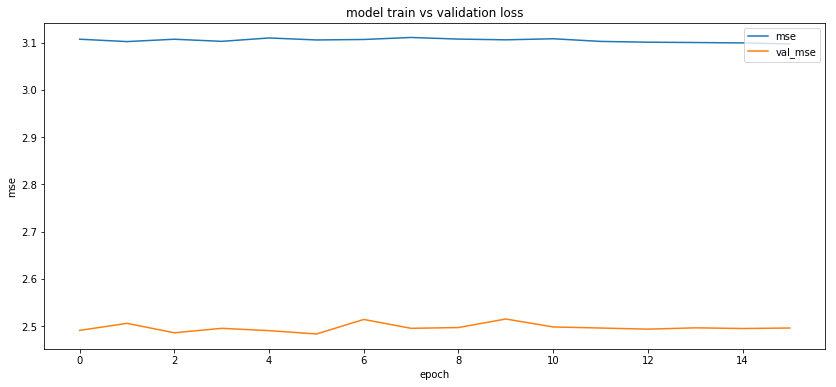

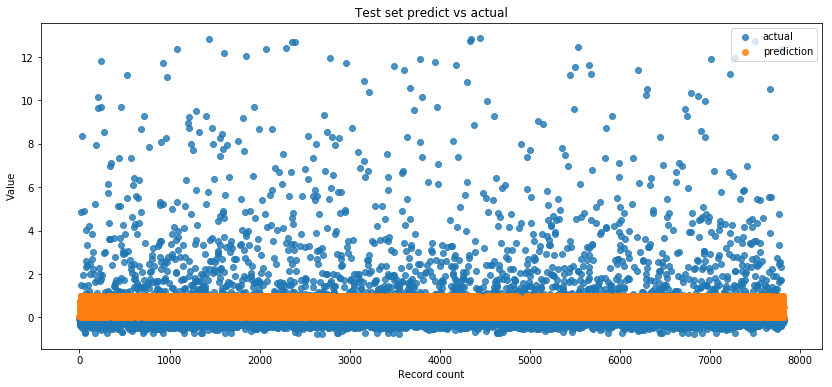

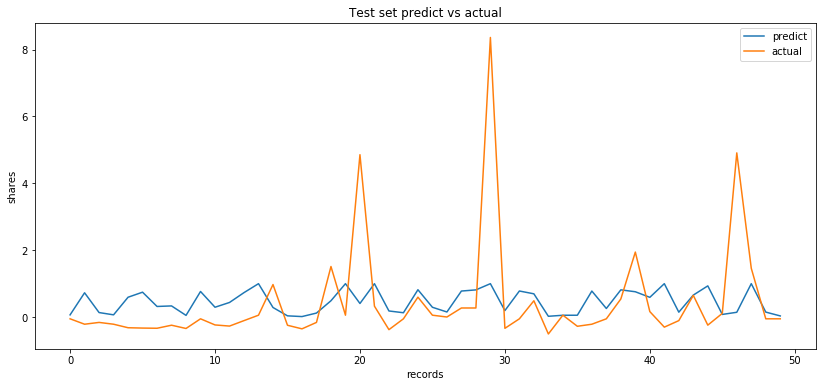

In [24]:
# showing results
scores = model.evaluate(x_test, y_test)

# http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
y_pred = model.predict(x_test)

root_mse = math.sqrt(scores[1])
var_score = explained_variance_score(y_pred, y_test)
mean_abs_error = mean_absolute_error(y_pred, y_test)
mean_sqare_log_error = mean_squared_log_error(y_pred, y_test)
median_abs_error = median_absolute_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)

print('actual max {0}'.format(np.max(y_test)))
print('actual min {0}'.format(np.min(y_test)))
print('actual median {0}'.format(np.median(y_test)))
print('predict max {0}'.format(np.max(y_pred)))
print('predict min {0}'.format(np.min(y_pred)))
print('predict median {0}'.format(np.median(y_pred)))
print()
print("{0}: {1}".format(model.metrics_names[0], round(scores[0], 6)))
print("{0}: {1}".format(model.metrics_names[1], round(scores[1], 6)))
print('root_mse: {0}'.format(round(root_mse, 6)))
print('explained_variance_score: {0}'.format(round(var_score, 6)))
print('mean_absolute_error: {0}'.format(round(mean_abs_error, 6)))
print('mean_squared_log_error: {0}'.format(round(mean_sqare_log_error, 6)))
print('median_absolute_error: {0}'.format(round(median_abs_error, 6)))
print('r2_score: {0}'.format(round(r2, 6)))

# plt.figure(figsize=(14,6))
# plt.hist(y_pred, 100)
# plt.hist(y_test, 100)
# plt.show()

plt.figure(figsize=(14,6))
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model train vs validation loss')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['mse', 'val_mse'], loc='upper right')
plt.show()

plt.figure(figsize=(14,6))
plt.xlabel("Record count")
plt.ylabel("Value")
plt.title("Test set predict vs actual")
x = list(range(len(y_pred)))
# plt.ylim(0, 1)
plt.scatter(x, [pt[0] for pt in y_test], label='actual', alpha=0.8)
plt.scatter(x, [pt[0] for pt in y_pred], label='prediction', alpha=0.8)
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(14,6))
plt.title('Test set predict vs actual')
plt.plot(y_pred[:50])
plt.plot(y_test[:50])
plt.ylabel('shares')
plt.xlabel('records')
plt.legend(['predict', 'actual'], loc='upper right', borderaxespad=0.5)
plt.show()

In [ ]:
# kfold on dataset and training
dataset = []
labels = []
dataset, labels = load_dataset(is_normalize=True)
print('Dataset shape: {0}, Labels: {1}'.format(dataset.shape, labels.shape))

kfold_result = []

kf = KFold(n_splits=5, shuffle=True, random_state=100)
for train_index, test_index in kf.split(dataset):
    x_train, x_test = dataset[train_index], dataset[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
#     print("x_train: {0}, y_train: {1}".format(x_train.shape, y_train.shape))
#     print("x_test: {0}, y_test: {1}".format(x_test.shape, y_test.shape))
    
    # build model
    model = Sequential()
    model.add(Dense(128, input_dim=58, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='mean_squared_error',
                  optimizer=RMSprop(lr=0.001),
                  metrics=['mse'])
    
    # train model
    early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.00001,
                           patience=10,
                           mode='min',
                           verbose=1)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.2,
                                  patience=4,
                                  min_lr=0.000001,
                                  verbose=1)

    model.fit(x_train, y_train,
              epochs=50,
              validation_data=(x_test, y_test),
              callbacks=[early_stop, reduce_lr],
              verbose=1)
    
    # evaluating model
    scores = model.evaluate(x_test, y_test)
    print("{0}: {1}".format(model.metrics_names[0], round(scores[0], 6)))
    print("{0}: {1}".format(model.metrics_names[1], round(scores[1], 6)))
    y_pred = model.predict(x_test)
    r2 = r2_score(y_pred, y_test)
    print('r2_score: {0}'.format(round(r2, 6)))
    kfold_result.append([scores[0], scores[1], r2])

In [ ]:
avg_loss = 0
avg_mse = 0
avg_r2 = 0

for idx, scores in enumerate(kfold_result):
    avg_loss += scores[0]
    avg_mse += scores[1]
    avg_r2 += scores[2]
    print('kfold {0}'.format(idx+1))
    print("{0}: {1}".format(model.metrics_names[0], round(scores[0], 6)))
    print("{0}: {1}".format(model.metrics_names[1], round(scores[1], 6)))
    print('r2_score: {0}'.format(round(scores[2], 6)))
    print()

print('kfold average loss: {0}'.format(round(avg_loss, 6)))
print('kfold average mse: {0}'.format(round(avg_mse, 6)))
print('kfold average r2: {0}'.format(round((avg_r2/5), 6)))